## Importación de Librerías

In [1]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt 
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Dataloader

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import cKDTree

category_mapping = {
    0: [43, 38, 58, 29, 41, 42, 44, 39, 55],  # Construction
    1: [4, 45, 6, 40, 60, 61, 33, 32, 14],  # Object
    2: [7, 22, 9, 26, 11, 21],  # Road
    3: [48, 47, 1, 19, 46, 10, 25],  # Sign
    4: [23, 3, 24, 31, 2],  # Terrain
    5: [51, 50, 5, 18],  # Drivable Vegetation
    6: [28, 27, 62, 52, 16, 30, 59, 17],  # Non Drivable Vegetation
    7: [13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63],  # Vehicle
    8: [8, 56, 0, 53, 54],  # Void
}

label_to_category = {label: cat for cat, labels in category_mapping.items() for label in labels}

def map_labels(labels: np.ndarray) -> np.ndarray:
    return np.array([label_to_category.get(label, 8) for label in labels], dtype=np.uint8)

def load_bin_file(bin_path: str, num_points: int, radius: float = 25.0):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    distances = np.linalg.norm(points, axis=1)
    mask = distances <= radius
    points = points[mask]
    num_available = points.shape[0]
    if num_available >= num_points:
        indices = np.random.choice(num_available, num_points, replace=False)
        return points[indices], np.where(mask)[0][indices]
    return None, None

def load_label_file(label_path: str, indices: np.ndarray) -> np.ndarray:
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    return map_labels(labels[indices])

def normalize_point_cloud(points):
    mean = np.mean(points, axis=0)  # Media por dimensión
    std = np.std(points, axis=0) + 1e-6  # Evitar divisiones por 0
    return (points - mean) / std

class GOOSEDataset(Dataset):
    def __init__(self, x_path, y_path, num_points=4096, mode='train', batch_size=32):
        self.x_files = sorted([os.path.join(x_path, f) for f in os.listdir(x_path) if f.endswith(".bin")])
        self.y_files = sorted([os.path.join(y_path, f) for f in os.listdir(y_path) if f.endswith(".label")])
        assert len(self.x_files) == len(self.y_files), "Número de archivos de entrada y etiquetas no coinciden"
        self.num_points = num_points
        self.batch_size = batch_size
        self.mode = mode

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        points, indices = load_bin_file(self.x_files[idx], self.num_points)

        if points is None or indices is None:
            return self.__getitem__((idx + 1) % len(self.x_files))  # Evitar devolver None

        labels = load_label_file(self.y_files[idx], indices)

        if labels is None:
            return self.__getitem__((idx + 1) % len(self.x_files))

        points = normalize_point_cloud(points)  # Aplica normalización

        return torch.tensor(points, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)

In [3]:
x_train_path = "/home/fmartinez/datasets/lidar/train"
y_train_path = "/home/fmartinez/datasets/labels/train"
x_val_path = "/home/fmartinez/datasets_val/lidar/val"
y_val_path = "/home/fmartinez/datasets_val/labels/val"

In [4]:
train_dataset = GOOSEDataset(x_train_path, y_train_path, num_points=16384, mode='train', batch_size=16)
val_dataset = GOOSEDataset(x_val_path, y_val_path, num_points=16384, mode='val', batch_size=16)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [6]:
import plotly.graph_objects as go
import pandas as pd

def plot_3D_colors(sampled_df):
    # Define color map and categories
    color_map = {
        0: 'purple',
        1: 'black',
        2: 'cyan',
        3: 'darkgreen',
        4: 'blue',
        5: 'limegreen',
        6: 'green',
        7: 'orange',
        8: 'red'
    }

    label_categories = [
        'Construction', 'Object', 'Road', 'Sign', 'Terrain',
        'Drivable Vegetation', 'Non Drivable Vegetation', 'Vehicle', 'Void'
    ]

    # Map label colors using apply to avoid NaN issues
    scatter_colors = sampled_df['label'].apply(lambda x: color_map.get(x, 'gray'))
    scatter_texts = sampled_df['label'].apply(lambda x: label_categories[x])  #  Nombre de la clase

    # Create a 3D scatter plot without adding it to the legend
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=sampled_df['x'],
        y=sampled_df['y'],
        z=sampled_df['z'],
        mode='markers',
        marker=dict(
            size=2,  # Ajustar tamaño del punto
            color=scatter_colors,  # Color por categoría
            opacity=0.7  # Ajustar opacidad
        ),
        text=scatter_texts,  #  Se muestra el nombre de la clase al pasar el mouse
        hoverinfo="text",  #  Muestra solo el texto en hover
        showlegend=False  # Evita que los puntos aparezcan en la leyenda
    ))

    # Add legend manually
    for label, color in color_map.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color),
            name=label_categories[label],
            showlegend=True  # 🔹 Solo estos elementos aparecen en la leyenda
        ))

    # Set labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Point Cloud with Label Colors',
        legend_title='Labels'
    )

    fig.show()

In [7]:
# Extract a batch from the train_loader
batch = next(iter(val_loader))

# Separate the point cloud data and labels
point_cloud_batch, labels_batch = batch

# Select the first sample in the batch (index 0)
sample_point_cloud = point_cloud_batch[0].numpy()
sample_labels = labels_batch[0].numpy()

In [8]:
# Convert the point cloud sample to a DataFrame
sampled_df = pd.DataFrame(sample_point_cloud, columns=['x', 'y', 'z'])
sampled_df['label'] = sample_labels
sampled_df.head()

,x,y,z,label
0,0.521673,0.583492,1.234699,6
1,-0.887311,0.438871,0.068202,5
2,1.042640,-1.568228,-1.124317,5
3,-0.824690,0.588347,0.669014,6
4,-1.573792,-0.336234,-1.589584,4


In [9]:
plot_3D_colors(sampled_df)

## PointNet

In [10]:
# T-net 
class Tnet(nn.Module):
    ''' T-Net learns a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points=16384):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim 

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)
        

    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)
        
        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x


# ============================================================================
# Point Net Backbone (main Architecture)
class PointNetBackbone(nn.Module):
    '''
    This is the main portion of Point Net before the classification and segmentation heads.
    The main function of this network is to obtain the local and global point features, 
    which can then be passed to each of the heads to perform either classification or
    segmentation. The forward pass through the backbone includes both T-nets and their 
    transformations, the shared MLPs, and the max pool layer to obtain the global features.

    The forward function either returns the global or combined (local and global features)
    along with the critical point index locations and the feature transformation matrix. The
    feature transformation matrix is used for a regularization term that will help it become
    orthogonal. (i.e. a rigid body transformation is an orthogonal transform and we would like
    to maintain orthogonality in high dimensional space). "An orthogonal transformations preserves
    the lengths of vectors and angles between them"
    ''' 
    def __init__(self, num_points=16384, num_global_feats=1024, local_feat=True):
        ''' Initializers:
                num_points - number of points in point cloud
                num_global_feats - number of Global Features for the main 
                                   Max Pooling layer
                local_feat - if True, forward() returns the concatenation 
                             of the local and global features
            '''
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)
        
        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)

    
    def forward(self, x):

        # get batch size
        bs = x.shape[0]
        
        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        
        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features, 
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)), 
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat



# ============================================================================
# Segmentation Head
class PointNetSegHead(nn.Module):
    ''' Segmentation Head '''
    def __init__(self, num_points=4096, num_global_feats=1024, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone 
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # shared MLP
        num_features = num_global_feats + 64 # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):
        
        # get combined features
        x, crit_idxs, A_feat = self.backbone(x) 

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)
        
        return x, crit_idxs, A_feat

In [11]:
seg_model = PointNetSegHead(num_points=16384, m=9)
points, targets = next(iter(train_loader))
out, _, _ = seg_model(points.transpose(2, 1))
print(f'Seg shape: {out.shape}')

Seg shape: torch.Size([16, 16384, 9])


In [12]:
# special loss for segmentation Focal Loss + Dice Loss
class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True, dice=False):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.dice = dice

        # sanitize inputs
        if isinstance(alpha,(float, int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,(list, np.ndarray)): self.alpha = torch.Tensor(alpha)

        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)
        

    def forward(self, predictions, targets, pred_choice=None):

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions.transpose(2, 1), targets)

        # reformat predictions (b, n, c) -> (b*n, c)
        predictions = predictions.contiguous() \
                                 .view(-1, predictions.size(2)) 
        # get predicted class probabilities for the true class
        pn = F.softmax(predictions)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # compute loss (negative sign is included in ce_loss)
        loss = ((1 - pn)**self.gamma * ce_loss)
        if self.size_average: loss = loss.mean() 
        else: loss = loss.sum()

        # add dice coefficient if necessary
        if self.dice: return loss + self.dice_loss(targets, pred_choice, eps=1)
        else: return loss


    @staticmethod
    def dice_loss(predictions, targets, eps=1):
        ''' Compute Dice loss, directly compare predictions with truth '''

        targets = targets.reshape(-1)
        predictions = predictions.reshape(-1)

        cats = torch.unique(targets)

        top = 0
        bot = 0
        for c in cats:
            locs = targets == c

            # get truth and predictions for each class
            y_tru = targets[locs]
            y_hat = predictions[locs]

            top += torch.sum(y_hat == y_tru)
            bot += len(y_tru) + len(y_hat)


        return 1 - 2*((top + eps)/(bot + eps)) 

## Entrenamiento

In [13]:
# Training hyperparameters

EPOCHS = 8
LR = 0.00000001
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


# manually set alpha weights
alpha = np.ones(9)
alpha[0] *= 0.8 # balance background classes
alpha[4] *= 0.6  # balance building class
alpha[5] *= 0.5  # balance building class
alpha[6] *= 0.3  # balance building class

gamma = 1

optimizer = optim.Adam(seg_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=1e-4, 
                                              step_size_up=1000, cycle_momentum=False)
criterion = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).to(DEVICE)

seg_model = seg_model.to(DEVICE)

cuda


In [14]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=9).to(DEVICE)

In [15]:
# We also want to track how well the models learns structure, so we will keep track of the IOU

def compute_iou(targets, predictions):

    targets = targets.reshape(-1)
    predictions = predictions.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union 

In [16]:
# store best validation iou
best_iou = 0.7
best_mcc = 0.7

# lists to store metrics
train_loss = []
train_accuracy = []
train_mcc = []
train_iou = []
valid_loss = []
valid_accuracy = []
valid_mcc = []
valid_iou = []

## Flujo de entrenamiento

In [ ]:
NUM_TRAIN_POINTS = 16384

# stuff for training
num_train_batch = int(np.ceil(len(train_dataset)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(val_dataset)/BATCH_SIZE))

for epoch in range(1, EPOCHS + 1):
    # place model in training mode
    seg_model = seg_model.train()
    _train_loss = []
    _train_accuracy = []
    _train_mcc = []
    _train_iou = []
    for i, (points, targets) in enumerate(train_loader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, _ = seg_model(points)

        # get class predictions
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        # get loss and perform backprop
        loss = criterion(preds, targets, pred_choice) 
        loss.backward()
        optimizer.step()
        scheduler.step() # update learning rate
        
        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())
        _train_iou.append(iou.item())

        if i % 500 == 0:
            print(f'\t [{epoch}: {i}/{num_train_batch}] ' \
                  + f'train loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))
    train_mcc.append(np.mean(_train_mcc))
    train_iou.append(np.mean(_train_iou))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]:.4f} ' \
          + f'- Train Accuracy: {train_accuracy[-1]:.4f} ' \
          + f'- Train MCC: {train_mcc[-1]:.4f} ' \
          + f'- Train IOU: {train_iou[-1]:.4f}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        seg_model = seg_model.eval()

        _valid_loss = []
        _valid_accuracy = []
        _valid_mcc = []
        _valid_iou = []
        for i, (points, targets) in enumerate(val_loader, 0):

            points = points.transpose(2, 1).to(DEVICE)
            targets = targets.to(DEVICE)
            if targets.dim() == 1:
                targets = targets.unsqueeze(0)  # Convierte (4096,) en (1, 4096)

            preds, _, A = seg_model(points)
            pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

            loss = criterion(preds, targets, pred_choice) 

            # get metrics
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct/float(BATCH_SIZE*NUM_TRAIN_POINTS)
            mcc = mcc_metric(preds.transpose(2, 1), targets)
            iou = compute_iou(targets, pred_choice)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)
            _valid_mcc.append(mcc.item())
            _valid_iou.append(iou.item())

            if i % 500 == 0:
                print(f'\t [{epoch}: {i}/{num_valid_batch}] ' \
                  + f'valid loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} '
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        valid_mcc.append(np.mean(_valid_mcc))
        valid_iou.append(np.mean(_valid_iou))
        print(f'Epoch: {epoch} - Valid Loss: {valid_loss[-1]:.4f} ' \
              + f'- Valid Accuracy: {valid_accuracy[-1]:.4f} ' \
              + f'- Valid MCC: {valid_mcc[-1]:.4f} ' \
              + f'- Valid IOU: {valid_iou[-1]:.4f}')


        # pause to cool down
        time.sleep(4)

	 [1: 0/483] train loss: 2.9563 accuracy: 0.1046 mcc: 0.0142 iou: 0.0552


## Evaluación

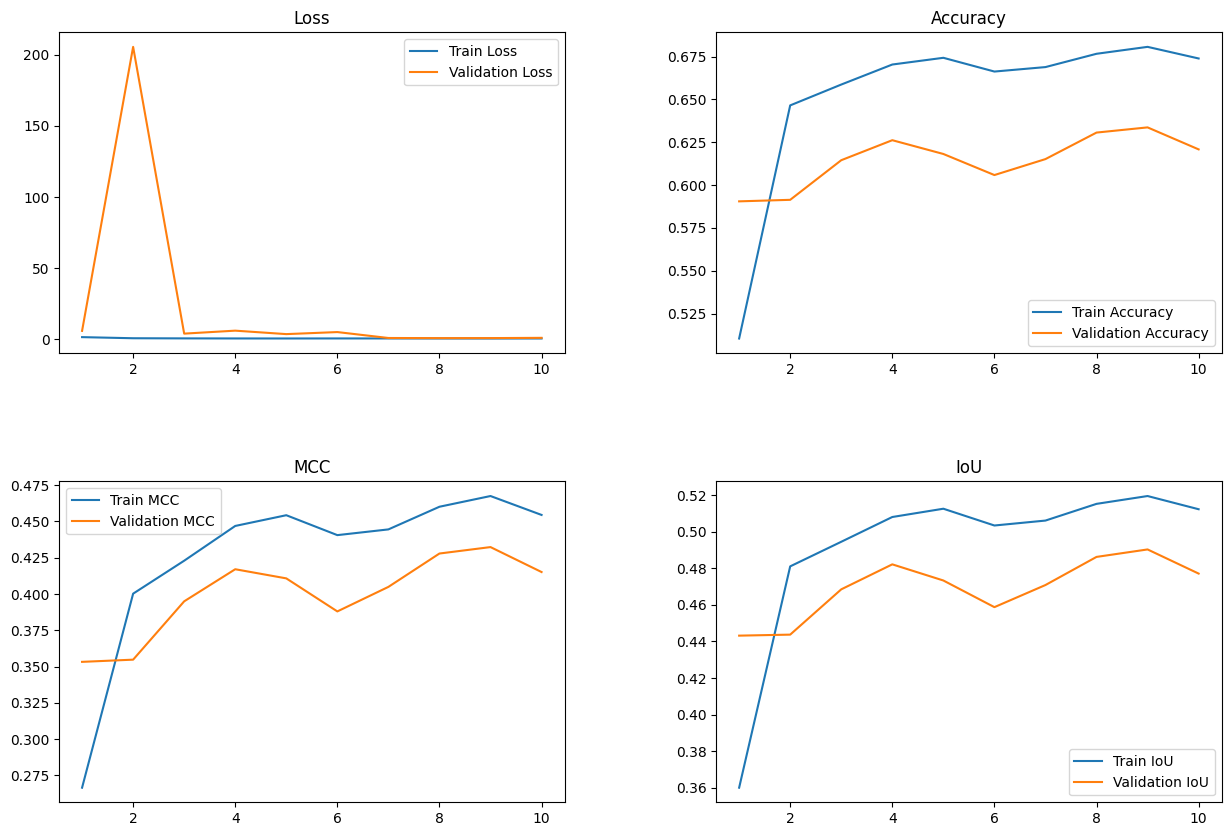

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].plot(np.arange(1, EPOCHS + 1), train_loss, label='Train Loss')
ax[0, 0].plot(np.arange(1, EPOCHS + 1), valid_loss, label='Validation Loss')
ax[0, 0].set_title('Loss')
ax[0, 0].legend()

ax[0, 1].plot(np.arange(1, EPOCHS + 1), train_accuracy, label='Train Accuracy')
ax[0, 1].plot(np.arange(1, EPOCHS + 1), valid_accuracy, label='Validation Accuracy')
ax[0, 1].set_title('Accuracy')
ax[0, 1].legend()

ax[1, 0].plot(np.arange(1, EPOCHS + 1), train_mcc, label='Train MCC')
ax[1, 0].plot(np.arange(1, EPOCHS + 1), valid_mcc, label='Validation MCC')
ax[1, 0].set_title('MCC')
ax[1, 0].legend()

ax[1, 1].plot(np.arange(1, EPOCHS + 1), train_iou, label='Train IoU')
ax[1, 1].plot(np.arange(1, EPOCHS + 1), valid_iou, label='Validation IoU')
ax[1, 1].set_title('IoU')
ax[1, 1].legend()

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

# MODEL TESTING

In [ ]:
import gc
import torch

# Clear unnecessary variables
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import os
import glob

model_dir = '/kaggle/working/trained_models'
files = glob.glob(os.path.join(model_dir, '*.pth'))

latest_model = files[-1]
latest_model

In [ ]:
MODEL_PATH = latest_model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4
NUM_TEST_POINTS = 8192

model = PointNetSegHead(num_points=NUM_TEST_POINTS, m=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print(DEVICE)

In [ ]:
test_dataset = PointCloudDataset(test_df, augmentation=False, num_points=NUM_TEST_POINTS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_test_batch = int(np.ceil(len(test_dataset)/BATCH_SIZE))

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    test_iou = []
    for i, (points, targets) in enumerate(test_loader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)

        preds, _, A = model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        loss = criterion(preds, targets, pred_choice)

        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(BATCH_SIZE*NUM_TEST_POINTS)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())
        test_iou.append(iou.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print(f'\t [{i}/{num_test_batch}] ' \
                  + f'test loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')

In [ ]:
# display test results
print(f'Test Loss: {np.mean(test_loss):.4f} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy):.4f} ' \
        + f'- Test MCC: {np.mean(test_mcc):.4f} ' \
        + f'- Test IOU: {np.mean(test_iou):.4f}')

In [ ]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)

In [ ]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(category_mapping.values()),
                              index=list(category_mapping.values()))

test_confusion

In [ ]:
# Plot the heatmap
category_labels = list(category_mapping.values())
plt.figure(figsize=(10, 8))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()